<h3 style="font-size:18px; font-family:Verdana" align="right"> Trokhymenko Viktor</h3>
<h5 style="font-size:14px; font-family:Verdana" align="right"> uds-club: vtrokhymenko</h5>

In [23]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)

from plotly import graph_objs as go

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
    
import matplotlib.pyplot as plt
%matplotlib inline

## подготовка данных

* #### цены с датами

In [24]:
df = pd.read_csv('../data/player_price.csv')

df['ds'] = pd.to_datetime(df['timestamp'], unit='ms')
df=df.loc[df["player_id"] == 222]
df.drop(["timestamp", "ps_price", "player_name", "player_id"], axis=1, inplace=True)
df.rename(columns={"xbox_price": "y"}, inplace=True)

#меняем 0 на 1
df=df.replace(0,1)

print(df.shape)
df.head()

(273, 2)


,y,ds
396632,9550,2016-09-23
396633,8825,2016-09-24
396634,8650,2016-09-25
396635,8757,2016-09-26
396636,8817,2016-09-27


In [25]:
df2plt=df.set_index('ds')

plotly_df(df2plt)
#df2plt.y.plot(figsize=(16,6))

## Prophet 
https://facebookincubator.github.io/prophet/docs/quick_start.html

pip install fbprophet

* #### на сколько дней будем предсказывать

In [26]:
predictions = 7
train_df = df[:-predictions]

* #### обучаем модель и предсказываем

In [27]:
%%time
m = Prophet()
m.fit(train_df)

future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Wall time: 2.51 s


* #### вся необходимая нам информация для прогноза

In [28]:
forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,seasonal,yhat
268,2017-06-18,1.011321,2434.947882,-3.623849,-3.623849,2434.703069,2435.470467,1383.936066,3590.808900,-3.623849,-3.623849,-3.623849,-3.623849,2431.324034
269,2017-06-19,1.015094,2432.109256,-69.311979,-69.311979,2430.740887,2434.507678,1253.188723,3498.706252,-69.311979,-69.311979,-69.311979,-69.311979,2362.797277
270,2017-06-20,1.018868,2429.270629,94.912767,94.912767,2426.469058,2434.465140,1385.033808,3648.270687,94.912767,94.912767,94.912767,94.912767,2524.183395
271,2017-06-21,1.022642,2426.432002,219.796039,219.796039,2421.757232,2434.056479,1519.467260,3835.835381,219.796039,219.796039,219.796039,219.796039,2646.228041
272,2017-06-22,1.026415,2423.593375,72.486812,72.486812,2416.706764,2434.009849,1306.414536,3636.060428,72.486812,72.486812,72.486812,72.486812,2496.080187


* #### построим графики

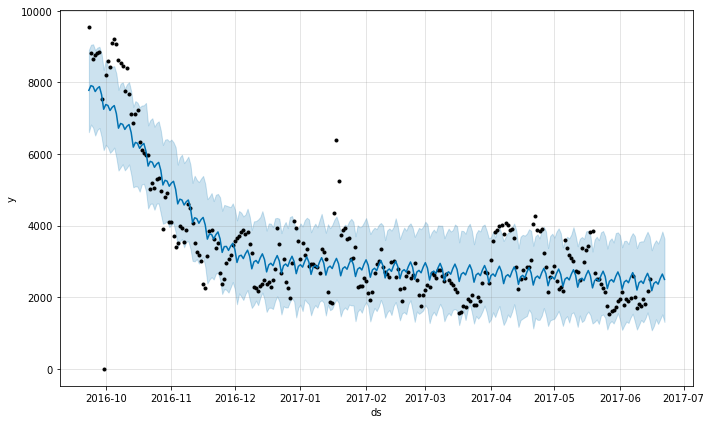

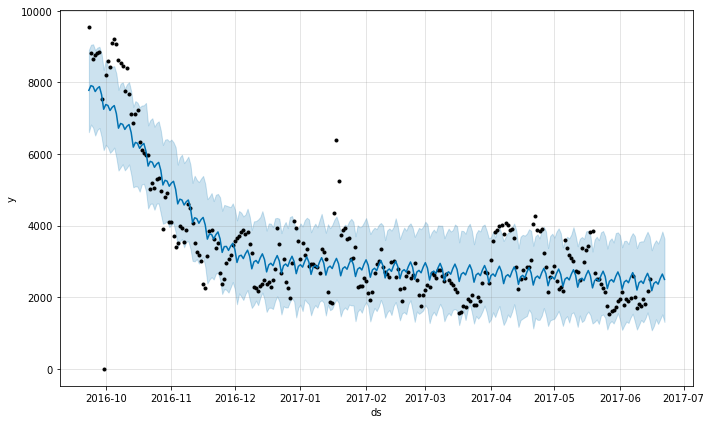

In [29]:
m.plot(forecast)

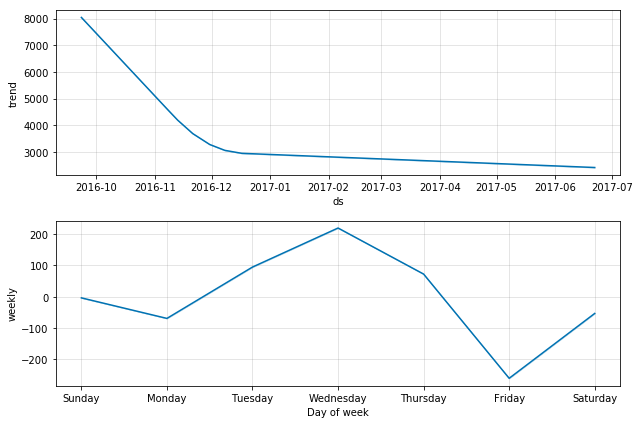

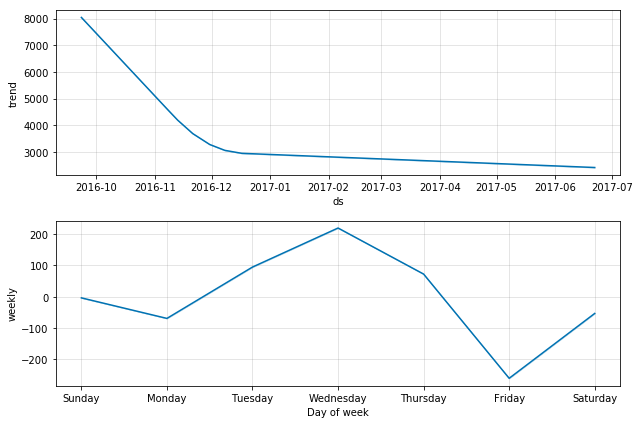

In [30]:
m.plot_components(forecast)

##### тренд есть
##### по недельной сезонности можно увидеть, что больше всего покупают данного игрока по средам

In [31]:
#объединяем forecast с исходными наблюдениями
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']

#считаем ошибки
print('MAPE', np.mean(abs(cmp_df[-predictions:]['p'])))
print('MAE', np.mean(abs(cmp_df[-predictions:]['e'])))
print('RMSE', mean_squared_error(df.y[-predictions:], cmp_df.yhat[-predictions:])**0.5)

MAPE 30.81708143299324
MAE 566.3949699418332
RMSE 587.845595218


In [32]:
init_notebook_mode(connected = True)

def show_forecast(cmp_df, num_predictions, num_values):
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_upper,
        mode='lines',
        marker=dict(color="444"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

    forecast = go.Scatter(
        name='Prediction',
        x=cmp_df.tail(predictions).index,
        y=cmp_df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

    lower_bound = go.Scatter(
        name='Lower Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_lower,
        marker=dict(color="444"),
        line=dict(width=0),
        mode='lines')

    fact = go.Scatter(
        name='Fact',
        x=cmp_df.tail(num_values).index,
        y=cmp_df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )

    # Trace order can be important
    # with continuous error bars
    data = [lower_bound, upper_bound, forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='price'),
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)
    
show_forecast(cmp_df, predictions, 300)

---

### Поиграемся с признаками

In [33]:
%%time
predictions = 7
train_df = df[:-predictions]

m = Prophet(changepoint_prior_scale=0.3, mcmc_samples=100)
m.fit(train_df)

future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']

print('MAPE', np.mean(abs(cmp_df[-predictions:]['p'])))
print('MAE', np.mean(abs(cmp_df[-predictions:]['e'])))
print('RMSE', mean_squared_error(df.y[-predictions:], cmp_df.yhat[-predictions:])**0.5)

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
MAPE 6.847841498552447
MAE 130.1645558730002
RMSE 180.756472826
Wall time: 1min 3s


In [34]:
%%time
predictions = 7
train_df = df[:-predictions]

m = Prophet(changepoint_prior_scale=0.3, interval_width=0.3)
m.fit(train_df)

future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']

print('MAPE', np.mean(abs(cmp_df[-predictions:]['p'])))
print('MAE', np.mean(abs(cmp_df[-predictions:]['e'])))
print('RMSE', mean_squared_error(df.y[-predictions:], cmp_df.yhat[-predictions:])**0.5)

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
MAPE 6.7747254771890795
MAE 127.80507253136248
RMSE 173.357312985
Wall time: 3.4 s


##### последние использованные параметры показали наименьшую ошибку

----

## теперь предскажем на 7 дней обучаясь с 2017-06-15

In [35]:
df_all = pd.read_csv('../data/player_price.csv')
df_all['ds'] = pd.to_datetime(df_all['timestamp'], unit='ms')
df_all=df_all[df_all.ds>='2017-06-15']
df_all.drop(["timestamp", "ps_price", "player_name"], axis=1, inplace=True)
df_all.rename(columns={"xbox_price": "y"}, inplace=True)
print(df_all.shape)
df_all.head()

(36786, 3)


,y,player_id,ds
265,3269308,1,2017-06-15
266,3212762,1,2017-06-16
267,3312852,1,2017-06-17
268,3227893,1,2017-06-18
269,3142655,1,2017-06-19


In [36]:
#id-шники игроков
sample_subm = pd.read_csv('../data/kaggle_sample_submission.csv')
sample_subm["player_id"] = sample_subm["id"].apply(lambda x: int(x.split("_")[0]))
player_id=sample_subm.groupby(['player_id'])['price'].count()

* #### код ниже будет выполнятся долго, так что подумайте перед тем как его запускать

In [37]:
%%time
k=0
for i in player_id.index:
    print('==================================')
    print('id={}'.format(i))
       
    df=df_all.loc[df_all['player_id'] == i]
    mediana=df.y[df.player_id==i].median()
    df.drop(['player_id'], axis=1, inplace=True)        
    #меняем 0 на медиану
    df=df.replace(0,int(mediana))
    
    train_df=df.copy()
    
    m=Prophet()
    m.fit(train_df)
    #if you have runtime error, comment above line and uncomment this one
    #m.fit(train_df, algorithm='Newton')
    
    future = m.make_future_dataframe(periods=7)
    forecast = m.predict(future)
    
    cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
    
    qwe=cmp_df.yhat[-7:] 
    
    pp=pd.DataFrame(columns=['id','price'])
    pp['id']=str(i)+'_'+qwe.index.astype(str)
    pp.price=qwe.values
    pp.price=pp.price.astype(int)
    print(pp)
    
    if k==0:
        pp.to_csv('prediction_fbpophet_test.csv',sep=',',header=True,index=False)
        k=1
    else:
        with open('prediction_fbpophet_test.csv', 'a') as f:
            pp.to_csv(f, header=False,index=False,sep=',')

id=1
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
             id    price
0  1_2017-06-23  3143976
1  1_2017-06-24  3129032
2  1_2017-06-25  3114088
3  1_2017-06-26  3099144
4  1_2017-06-27  3084200
5  1_2017-06-28  3069256
6  1_2017-06-29  3054312
id=2
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
             id   price
0  2_2017-06-23  743312
1  2_2017-06-24  744111
2  2_2017-06-25  744910
3  2_2017-06-26  745709
4  2_2017-06-27  746508
5  2_2017-06-28  747307
6  2_2017-06-29  748106
id=3
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
             id   price
0  3_2017-06-23  378332
1  3_2017-0

              id  price
0  21_2017-06-23  55199
1  21_2017-06-24  54722
2  21_2017-06-25  54245
3  21_2017-06-26  53767
4  21_2017-06-27  53290
5  21_2017-06-28  52813
6  21_2017-06-29  52335
id=22
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
              id  price
0  22_2017-06-23  35329
1  22_2017-06-24  34957
2  22_2017-06-25  34584
3  22_2017-06-26  34212
4  22_2017-06-27  33839
5  22_2017-06-28  33467
6  22_2017-06-29  33094
id=23
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
              id   price
0  23_2017-06-23  204425
1  23_2017-06-24  206676
2  23_2017-06-25  208926
3  23_2017-06-26  211176
4  23_2017-06-27  213427
5  23_2017-06-28  215677
6  23_2017-06-29  217927
id=24
Disabling yearly seasonality. Run prophet 

              id  price
0  41_2017-06-23  14882
1  41_2017-06-24  14761
2  41_2017-06-25  14640
3  41_2017-06-26  14519
4  41_2017-06-27  14398
5  41_2017-06-28  14278
6  41_2017-06-29  14157
id=42
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
              id  price
0  42_2017-06-23  23251
1  42_2017-06-24  22834
2  42_2017-06-25  22417
3  42_2017-06-26  22000
4  42_2017-06-27  21583
5  42_2017-06-28  21166
6  42_2017-06-29  20749
id=43
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
              id   price
0  43_2017-06-23  126188
1  43_2017-06-24  125656
2  43_2017-06-25  125125
3  43_2017-06-26  124593
4  43_2017-06-27  124061
5  43_2017-06-28  123530
6  43_2017-06-29  122998
id=44
Disabling yearly seasonality. Run prophet 

              id   price
0  61_2017-06-23  212895
1  61_2017-06-24  209463
2  61_2017-06-25  206030
3  61_2017-06-26  202598
4  61_2017-06-27  199166
5  61_2017-06-28  195733
6  61_2017-06-29  192301
id=62
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
              id   price
0  62_2017-06-23  136697
1  62_2017-06-24  134421
2  62_2017-06-25  132145
3  62_2017-06-26  129869
4  62_2017-06-27  127593
5  62_2017-06-28  125316
6  62_2017-06-29  123040
id=63
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
              id   price
0  63_2017-06-23  495173
1  63_2017-06-24  499555
2  63_2017-06-25  503937
3  63_2017-06-26  508319
4  63_2017-06-27  512701
5  63_2017-06-28  517083
6  63_2017-06-29  521465
id=64
Disabling yearly seasonali

              id   price
0  81_2017-06-23  126839
1  81_2017-06-24  127475
2  81_2017-06-25  128111
3  81_2017-06-26  128747
4  81_2017-06-27  129383
5  81_2017-06-28  130019
6  81_2017-06-29  130655
id=82
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
              id   price
0  82_2017-06-23  147939
1  82_2017-06-24  145848
2  82_2017-06-25  143756
3  82_2017-06-26  141664
4  82_2017-06-27  139572
5  82_2017-06-28  137480
6  82_2017-06-29  135389
id=83
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
              id   price
0  83_2017-06-23  114933
1  83_2017-06-24  115190
2  83_2017-06-25  115448
3  83_2017-06-26  115705
4  83_2017-06-27  115962
5  83_2017-06-28  116220
6  83_2017-06-29  116477
id=84
Disabling yearly seasonali

               id  price
0  101_2017-06-23  31899
1  101_2017-06-24  31838
2  101_2017-06-25  31777
3  101_2017-06-26  31716
4  101_2017-06-27  31655
5  101_2017-06-28  31594
6  101_2017-06-29  31534
id=102
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
               id  price
0  102_2017-06-23   8625
1  102_2017-06-24   8469
2  102_2017-06-25   8313
3  102_2017-06-26   8156
4  102_2017-06-27   8000
5  102_2017-06-28   7844
6  102_2017-06-29   7688
id=103
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
               id  price
0  103_2017-06-23   8872
1  103_2017-06-24   8817
2  103_2017-06-25   8762
3  103_2017-06-26   8707
4  103_2017-06-27   8652
5  103_2017-06-28   8597
6  103_2017-06-29   8542
id=104
Disabling yearly season

               id  price
0  121_2017-06-23   7098
1  121_2017-06-24   7069
2  121_2017-06-25   7040
3  121_2017-06-26   7011
4  121_2017-06-27   6982
5  121_2017-06-28   6953
6  121_2017-06-29   6924
id=122
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
               id  price
0  122_2017-06-23   7312
1  122_2017-06-24   7252
2  122_2017-06-25   7191
3  122_2017-06-26   7131
4  122_2017-06-27   7071
5  122_2017-06-28   7010
6  122_2017-06-29   6950
id=123
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
               id  price
0  123_2017-06-23   7318
1  123_2017-06-24   7269
2  123_2017-06-25   7220
3  123_2017-06-26   7172
4  123_2017-06-27   7123
5  123_2017-06-28   7074
6  123_2017-06-29   7025
id=124
Disabling yearly season

               id  price
0  141_2017-06-23   8525
1  141_2017-06-24   8479
2  141_2017-06-25   8433
3  141_2017-06-26   8387
4  141_2017-06-27   8340
5  141_2017-06-28   8294
6  141_2017-06-29   8248
id=142
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
               id  price
0  142_2017-06-23   6169
1  142_2017-06-24   6128
2  142_2017-06-25   6087
3  142_2017-06-26   6046
4  142_2017-06-27   6005
5  142_2017-06-28   5964
6  142_2017-06-29   5923
id=143
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
               id  price
0  143_2017-06-23   6766
1  143_2017-06-24   6086
2  143_2017-06-25   5405
3  143_2017-06-26   4725
4  143_2017-06-27   4045
5  143_2017-06-28   3364
6  143_2017-06-29   2684
id=144
Disabling yearly season

               id  price
0  161_2017-06-23   4996
1  161_2017-06-24   4936
2  161_2017-06-25   4875
3  161_2017-06-26   4815
4  161_2017-06-27   4754
5  161_2017-06-28   4694
6  161_2017-06-29   4633
id=162
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
               id  price
0  162_2017-06-23   5073
1  162_2017-06-24   5046
2  162_2017-06-25   5018
3  162_2017-06-26   4991
4  162_2017-06-27   4964
5  162_2017-06-28   4937
6  162_2017-06-29   4910
id=163
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
               id  price
0  163_2017-06-23  33314
1  163_2017-06-24  33095
2  163_2017-06-25  32875
3  163_2017-06-26  32656
4  163_2017-06-27  32436
5  163_2017-06-28  32217
6  163_2017-06-29  31997
id=164
Disabling yearly season

               id  price
0  181_2017-06-23   3390
1  181_2017-06-24   3386
2  181_2017-06-25   3383
3  181_2017-06-26   3380
4  181_2017-06-27   3377
5  181_2017-06-28   3373
6  181_2017-06-29   3370
id=182
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
               id  price
0  182_2017-06-23  17320
1  182_2017-06-24  17396
2  182_2017-06-25  17473
3  182_2017-06-26  17550
4  182_2017-06-27  17627
5  182_2017-06-28  17704
6  182_2017-06-29  17781
id=183
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
               id  price
0  183_2017-06-23   2987
1  183_2017-06-24   2918
2  183_2017-06-25   2849
3  183_2017-06-26   2780
4  183_2017-06-27   2711
5  183_2017-06-28   2642
6  183_2017-06-29   2573
id=184
Disabling yearly season

               id  price
0  201_2017-06-23   2606
1  201_2017-06-24   2253
2  201_2017-06-25   1900
3  201_2017-06-26   1547
4  201_2017-06-27   1193
5  201_2017-06-28    840
6  201_2017-06-29    487
id=202
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
               id  price
0  202_2017-06-23   3083
1  202_2017-06-24   3015
2  202_2017-06-25   2947
3  202_2017-06-26   2879
4  202_2017-06-27   2811
5  202_2017-06-28   2744
6  202_2017-06-29   2676
id=203
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
               id  price
0  203_2017-06-23   3375
1  203_2017-06-24   3337
2  203_2017-06-25   3298
3  203_2017-06-26   3260
4  203_2017-06-27   3221
5  203_2017-06-28   3183
6  203_2017-06-29   3144
id=204
Disabling yearly season

               id  price
0  245_2017-06-23   4631
1  245_2017-06-24   4820
2  245_2017-06-25   5009
3  245_2017-06-26   5198
4  245_2017-06-27   5387
5  245_2017-06-28   5576
6  245_2017-06-29   5766
id=246
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
               id  price
0  246_2017-06-23   2935
1  246_2017-06-24   2818
2  246_2017-06-25   2701
3  246_2017-06-26   2585
4  246_2017-06-27   2468
5  246_2017-06-28   2351
6  246_2017-06-29   2234
id=254
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
               id  price
0  254_2017-06-23   2757
1  254_2017-06-24   2679
2  254_2017-06-25   2601
3  254_2017-06-26   2523
4  254_2017-06-27   2445
5  254_2017-06-28   2367
6  254_2017-06-29   2289
id=264
Disabling yearly season

               id  price
0  422_2017-06-23   3549
1  422_2017-06-24   3367
2  422_2017-06-25   3184
3  422_2017-06-26   3002
4  422_2017-06-27   2819
5  422_2017-06-28   2636
6  422_2017-06-29   2454
id=469
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
               id  price
0  469_2017-06-23   2850
1  469_2017-06-24   2711
2  469_2017-06-25   2572
3  469_2017-06-26   2433
4  469_2017-06-27   2294
5  469_2017-06-28   2155
6  469_2017-06-29   2016
id=525
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
               id  price
0  525_2017-06-23   4914
1  525_2017-06-24   5084
2  525_2017-06-25   5253
3  525_2017-06-26   5422
4  525_2017-06-27   5592
5  525_2017-06-28   5761
6  525_2017-06-29   5930
id=556
Disabling yearly season

KeyboardInterrupt: 

# заключение
- данная реализация дала скор на лидерборде чуть больше 18K
- делал валидацию на последней неделе - не помогло (кормил с 2017-02-01)
- пытался при обучении использовать другие параметры, но это не улучшило скор для общей картины